Daily Demand Forecast V4.0
--

V3.0
  - Put all 5000+ zones together.
  - In addition to the feathers already used, add average weekly demand for the past 1, 2, 3, and 4 weeks.
  
V4.0
  - Explore and play with different features.
  - Add in_holiday instead of each holiday
  - Add May and September indicators

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
import math
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Solve problem with xgb error

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
file_demand = '../5000+_Zones/20160601_20190714 5000+ Demands.csv'
file_forecast = '../5000+_Zones/20160601_20190714 5000+ Forecasts.csv'

In [4]:
# Read in daily forecast and demand.

# Forecast
forecast = pd.read_csv(file_forecast)
forecast.rename(columns={i:i.lower() for i in forecast.columns.tolist()}, inplace=True)
forecast.drop(columns=['unnamed: 0'], axis=1, inplace=True)
forecast['date'] = pd.to_datetime(forecast['date'], infer_datetime_format=True)
forecast['date'] = forecast['date'].map(lambda x: x.date())

# Demand
demand = pd.read_csv(file_demand)
demand.rename(columns={i:i.lower() for i in demand.columns.tolist()}, inplace=True)
demand.drop(columns=['unnamed: 0'], axis=1, inplace=True)
demand['date'] = pd.to_datetime(demand['date'], infer_datetime_format=True)
demand['date'] = demand['date'].map(lambda x: x.date())

# Join forecast and demand together
df = demand.merge(forecast.rename(columns={'demand':'forecast'}), on=['zone_id', 'date'])

# Get APE
df['err'] = (df['forecast'] - df['demand']) / df['demand']
df['ape'] = df['err'].map(lambda x: abs(x))

# Get MAPE
df['year'] = df['date'].map(lambda x: x.year)
df['month'] = df['date'].map(lambda x: x.month)
df['week'] = df['date'].map(lambda x: x.isocalendar()[1])
df['weekday'] = df['date'].map(lambda x: x.weekday())
df['month_1st'] = df['date'].map(lambda x: datetime(x.year, x.month, 1).date())
df_mape = df[['zone_id', 'month_1st', 'ape']].groupby(['zone_id', 'month_1st']).mean()\
        .reset_index().rename(columns={'ape':'mape', 'month_1st':'date'})
df_mape.sort_values(by=['zone_id', 'date'], inplace=True)

In [5]:
df.head(3)

,zone_id,date,demand,forecast,err,ape,year,month,week,weekday,month_1st
0,1,2016-06-01,2060.850413,1800.89,-0.126142,0.126142,2016,6,22,2,2016-06-01
1,1,2016-06-02,1691.095411,1716.02,0.014739,0.014739,2016,6,22,3,2016-06-01
2,1,2016-06-03,1487.825982,1616.19,0.086276,0.086276,2016,6,22,4,2016-06-01


In [6]:
df.zone_id.unique()

array([   1,   16,   27,   32,   33,   43,   79,   87,  131,  144,  183,
        392,  713,  714,  783,  785,  787,  839,  861,  942,  943,  945,
        972,  973,  974,  975,  979,  980,  981,  982,  983,  989, 1001,
       1002])

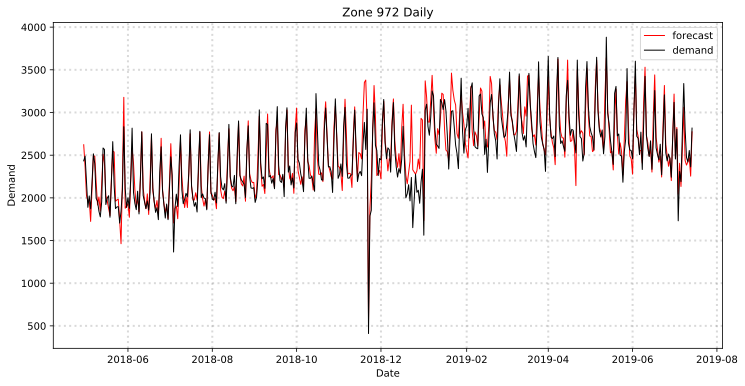

In [7]:
zone_id = 972

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(111)
ax1.plot(df[df['zone_id'] == zone_id]['date'],
         df[df['zone_id'] == zone_id]['forecast'], color='red', linewidth=1)
ax1.plot(df[df['zone_id'] == zone_id]['date'],
         df[df['zone_id'] == zone_id]['demand'], color='black', linewidth=1)
ax1.set_ylabel('Demand')
ax1.set_xlabel('Date')
ax1.legend(loc='best')
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(['forecast', 'demand'])
ax1.set_title('Zone ' + str(zone_id) + ' Daily')
plt.show()

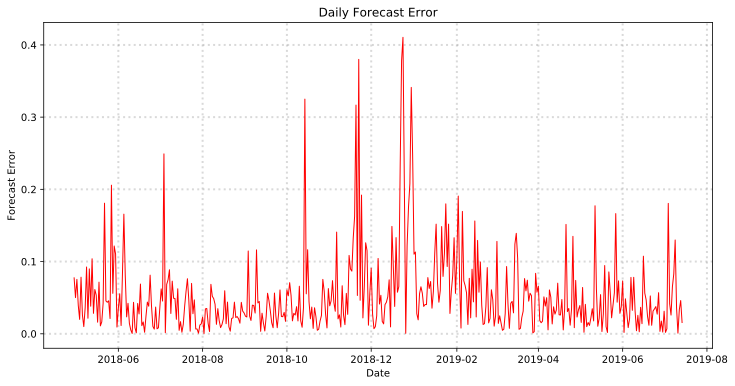

In [8]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(111)
ax1.plot(df[df['zone_id'] == zone_id]['date'],
         df[df['zone_id'] == zone_id]['ape'], color='red', linewidth=1)
ax1.set_ylabel('Forecast Error')
ax1.set_xlabel('Date')
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_title('Daily Forecast Error')
plt.show()

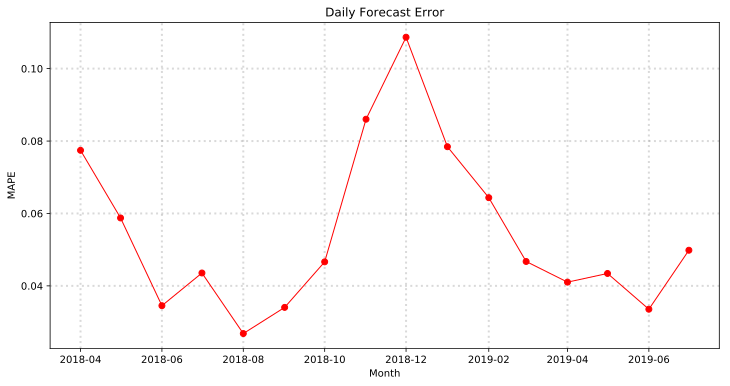

In [9]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(111)
ax1.plot(df_mape[df_mape['zone_id'] == zone_id]['date'],
         df_mape[df_mape['zone_id'] == zone_id]['mape'], 'o-', color='red', linewidth=1)
ax1.set_ylabel('MAPE')
ax1.set_xlabel('Month')
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
if False:
    for i, v in enumerate(df_mape['mape']):
        ax1.text(i + 0.2, v + 0.001, str(round(v, 2)),\
             color='#7663b0', fontweight='bold', fontsize=8)
ax1.set_title('Daily Forecast Error')
plt.show()

### Feature Engineering

In [10]:
# Read in holidays

calendar = pd.read_csv('../HolidaysForForecastAdjustments.csv')
calendar.dropna(inplace=True, axis=1, how='all')
calendar.dropna(inplace=True, axis=0, how='all')
calendar_BAK = calendar.copy()

df_2016 = calendar_BAK[['2016', 'Holiday']].copy().rename(columns={'2016':'date'})
df_2017 = calendar_BAK[['2017', 'Holiday']].copy().rename(columns={'2017':'date'})
df_2018 = calendar_BAK[['2018', 'Holiday']].copy().rename(columns={'2018':'date'})
df_2019 = calendar_BAK[['2019', 'Holiday']].copy().rename(columns={'2019':'date'})
df_2020 = calendar_BAK[['2020', 'Holiday']].copy().rename(columns={'2020':'date'})
calendar = pd.concat([df_2016, df_2017, df_2018, df_2019, df_2020])
calendar['date'] = pd.to_datetime(calendar['date'], infer_datetime_format=True)
calendar['date'] = calendar['date'].map(lambda x: x.date())

# Join with demand and forecast
df = df.merge(calendar, on='date', how='left')

In [11]:
df.head(3)

,zone_id,date,demand,forecast,err,ape,year,month,week,weekday,month_1st,Holiday
0,1,2016-06-01,2060.850413,1800.89,-0.126142,0.126142,2016,6,22,2,2016-06-01,NaN
1,1,2016-06-02,1691.095411,1716.02,0.014739,0.014739,2016,6,22,3,2016-06-01,NaN
2,1,2016-06-03,1487.825982,1616.19,0.086276,0.086276,2016,6,22,4,2016-06-01,NaN


In [12]:
# Use lags for prediction
# Use date = date_lag7 to get demand_lag7, ...

df['date_lag7'] = df['date'].map(lambda x: x + timedelta(7))
df = df.drop(columns=['date_lag7'], axis=1)\
    .merge(df[['zone_id', 'date_lag7', 'demand']].rename(columns={'demand':'demand_lag7'}),
             left_on=['zone_id', 'date'], right_on=['zone_id', 'date_lag7'], how='left')

df['date_lag14'] = df['date'].map(lambda x: x + timedelta(14))
df = df.drop(columns=['date_lag14'], axis=1)\
    .merge(df[['zone_id', 'date_lag14', 'demand']].rename(columns={'demand':'demand_lag14'}),
             left_on=['zone_id', 'date'], right_on=['zone_id', 'date_lag14'], how='left')

df['date_lag21'] = df['date'].map(lambda x: x + timedelta(21))
df = df.drop(columns=['date_lag21'], axis=1)\
    .merge(df[['zone_id', 'date_lag21', 'demand']].rename(columns={'demand':'demand_lag21'}),
             left_on=['zone_id', 'date'], right_on=['zone_id', 'date_lag21'], how='left')

df['date_lag28'] = df['date'].map(lambda x: x + timedelta(28))
df = df.drop(columns=['date_lag28'], axis=1)\
    .merge(df[['zone_id', 'date_lag28', 'demand']].rename(columns={'demand':'demand_lag28'}),
             left_on=['zone_id', 'date'], right_on=['zone_id', 'date_lag28'], how='left')

df['date_lag35'] = df['date'].map(lambda x: x + timedelta(35))
df = df.drop(columns=['date_lag35'], axis=1)\
    .merge(df[['zone_id', 'date_lag35', 'demand']].rename(columns={'demand':'demand_lag35'}),
             left_on=['zone_id', 'date'], right_on=['zone_id', 'date_lag35'], how='left')

df['date_lag42'] = df['date'].map(lambda x: x + timedelta(42))
df = df.drop(columns=['date_lag42'], axis=1)\
    .merge(df[['zone_id', 'date_lag42', 'demand']].rename(columns={'demand':'demand_lag42'}),
             left_on=['zone_id', 'date'], right_on=['zone_id', 'date_lag42'], how='left')

In [13]:
zone_id = 974

df[(df['date'] >= datetime(2018,12,1).date())\
  & (df['date'] <= datetime(2018,12,31).date())\
  & (df['zone_id'] == zone_id)][['zone_id', 'date', 'demand', 'demand_lag7', 
                                                 'demand_lag14', 'demand_lag21', 'demand_lag28',
                                                 'demand_lag35', 'demand_lag42']].head(30)

,zone_id,date,demand,demand_lag7,demand_lag14,demand_lag21,demand_lag28,demand_lag35,demand_lag42
19113,974,2018-12-01,2821.520066,1754.827815,2493.991672,2376.246946,2160.651978,2096.265264,2257.068618
19114,974,2018-12-02,3393.739785,3498.894284,2739.656544,3031.748995,3103.096927,3009.860320,2927.177448
19115,974,2018-12-03,2741.557399,2411.476411,2190.709280,2701.709765,2723.756306,2672.580036,2570.248828
19116,974,2018-12-04,2311.892637,2838.813058,1888.926981,1962.712774,2020.672219,2100.606147,1915.761850
19117,974,2018-12-05,2088.943194,2539.846138,2497.704703,1860.929294,1780.839786,1809.528757,1772.626102
19118,974,2018-12-06,1979.861982,2275.149133,308.818431,1994.673832,1785.243977,1777.315367,1808.910250
19119,974,2018-12-07,2209.606490,2305.645413,1389.223627,2202.746817,2116.670782,2092.919027,2033.092926
19120,974,2018-12-08,2583.950799,2821.520066,1754.827815,2493.991672,2376.246946,2160.651978,2096.265264
19121,974,2018-12-09,3178.153714,3393.739785,3498.894284,2739.656544,3031.748995,3103.096927,3009.860320
19122,974,2018-12-10,2822.515990,2741.557399,2411.476411,2190.709280,2701.709765,2723.756306,2672.580036


### Add the average weekly demand for the past 6 weeks

In [14]:
df_week_avg_lag1 = df[['zone_id', 'year', 'week', 'demand_lag7']]\
    .groupby(['zone_id', 'year', 'week']).mean().reset_index()\
    .rename(columns={'demand_lag7':'week_avg_lag1'})

df_week_avg_lag2 = df[['zone_id', 'year', 'week', 'demand_lag14']]\
    .groupby(['zone_id', 'year', 'week']).mean().reset_index()\
    .rename(columns={'demand_lag14':'week_avg_lag2'})

df_week_avg_lag3 = df[['zone_id', 'year', 'week', 'demand_lag21']]\
    .groupby(['zone_id', 'year', 'week']).mean().reset_index()\
    .rename(columns={'demand_lag21':'week_avg_lag3'})

df_week_avg_lag4 = df[['zone_id', 'year', 'week', 'demand_lag28']]\
    .groupby(['zone_id', 'year', 'week']).mean().reset_index()\
    .rename(columns={'demand_lag28':'week_avg_lag4'})

df_week_avg_lag5 = df[['zone_id', 'year', 'week', 'demand_lag35']]\
    .groupby(['zone_id', 'year', 'week']).mean().reset_index()\
    .rename(columns={'demand_lag35':'week_avg_lag5'})

df_week_avg_lag6 = df[['zone_id', 'year', 'week', 'demand_lag42']]\
    .groupby(['zone_id', 'year', 'week']).mean().reset_index()\
    .rename(columns={'demand_lag42':'week_avg_lag6'})

In [15]:
# Join the weekly lag average together.

df = df.merge(df_week_avg_lag1, on=['zone_id', 'year', 'week'])
df = df.merge(df_week_avg_lag2, on=['zone_id', 'year', 'week'])
df = df.merge(df_week_avg_lag3, on=['zone_id', 'year', 'week'])
df = df.merge(df_week_avg_lag4, on=['zone_id', 'year', 'week'])
df = df.merge(df_week_avg_lag5, on=['zone_id', 'year', 'week'])
df = df.merge(df_week_avg_lag6, on=['zone_id', 'year', 'week'])

### One Hot Encoding For Holidays

In [16]:
LaborDayWeekend = [datetime(2016,9,5,0,0).date(), datetime(2016,9,4,0,0).date(), datetime(2016,9,3,0,0).date(),
                  datetime(2017,9,4,0,0).date(), datetime(2017,9,3,0,0).date(), datetime(2017,9,2,0,0).date(),
                  datetime(2018,9,3,0,0).date(), datetime(2018,9,2,0,0).date(), datetime(2018,9,1,0,0).date(),
                  datetime(2019,9,2,0,0).date(), datetime(2019,9,1,0,0).date(), datetime(2019,8,31,0,0).date()]
WeekAfterLaborDay = [datetime(2016,9,6,0,0).date(), datetime(2016,9,7,0,0).date(), datetime(2016,9,8,0,0).date(),
                    datetime(2016,9,9,0,0).date(), datetime(2016,9,10,0,0).date(), datetime(2016,9,11,0,0).date(),
                    datetime(2017,9,5,0,0).date(), datetime(2017,9,6,0,0).date(), datetime(2017,9,7,0,0).date(), 
                     datetime(2017,9,8,0,0).date(), datetime(2017,9,9,0,0).date(), datetime(2017,9,10,0,0).date(),
                    datetime(2018,9,4,0,0).date(), datetime(2018,9,5,0,0).date(), datetime(2018,9,6,0,0).date(),
                    datetime(2018,9,7,0,0).date(), datetime(2018,9,8,0,0).date(), datetime(2018,9,9,0,0).date(),
                    datetime(2019,9,3,0,0).date(), datetime(2019,9,4,0,0).date(), datetime(2019,9,5,0,0).date(), 
                     datetime(2019,9,6,0,0).date(), datetime(2019,9,7,0,0).date(), datetime(2019,9,8,0,0).date()]
BeforeThanksgiving = [datetime(2016,11,23,0,0).date(), datetime(2017,11,22,0,0).date(),
                     datetime(2018,11,21,0,0).date(), datetime(2019,11,27,0,0).date()]
BeforeXEve = [datetime(2016,12,23,0,0).date(), datetime(2017,12,23,0,0).date(),
             datetime(2018,12,23,0,0).date(), datetime(2019,12,23,0,0).date()]
MemorialWeekend = [datetime(2016,5,30,0,0).date(), datetime(2016,5,29,0,0).date(),  datetime(2016,5,28,0,0).date(), 
                  datetime(2017,5,29,0,0).date(), datetime(2017,5,28,0,0).date(), datetime(2017,5,27,0,0).date(),
                  datetime(2018,5,28,0,0).date(), datetime(2018,5,27,0,0).date(), datetime(2018,5,26,0,0).date(),
                  datetime(2019,5,27,0,0).date(), datetime(2019,5,26,0,0).date(), datetime(2019,5,25,0,0).date()]
XEve = [datetime(2016,12,24,0,0).date(), datetime(2017,12,24,0,0).date(),
       datetime(2018,12,24,0,0).date(), datetime(2019,12,24,0,0).date()]

df['labordayweekend'] = df['date'].isin(LaborDayWeekend)
df['weekafterlaborday'] = df['date'].isin(WeekAfterLaborDay)
df['beforethanksgibving'] = df['date'].isin(BeforeThanksgiving)
df['beforexeve'] = df['date'].isin(BeforeXEve)
df['memorialweekend'] = df['date'].isin(MemorialWeekend)
df['xeve'] = df['date'].isin(XEve)

for i in ['labordayweekend', 'weekafterlaborday', 'beforethanksgibving', 
          'beforexeve', 'memorialweekend', 'xeve']:
    df[i] = df[i].map(lambda x: 1 if x == True else 0)

In [17]:
# Holidays
holidays = df[df['Holiday'].notnull()]['Holiday'].unique().tolist()
df['is_holiday'] = df['Holiday'].map(lambda x: 1 if x != None else 0)
for i in holidays:
    df[i] = df['Holiday'].map(lambda x: 1 if x == i else 0)

# To Thanksgiving    
txgv_2016 = datetime(2016,11,24,0,0).date()
txgv_2017 = datetime(2017,11,23,0,0).date()
txgv_2018 = datetime(2018,11,22,0,0).date()
txgv_2019 = datetime(2019,11,28,0,0).date()
txgv_2020 = datetime(2020,11,26,0,0).date()
df['to_thanksgiving'] = df['date'].map(lambda x: (x - txgv_2016).days if x.year == 2016 else\
                                      (x - txgv_2017).days if x.year == 2017 else
                                      (x - txgv_2018).days if x.year == 2018 else 
                                      (x - txgv_2019).days if x.year == 2019 else
                                      (x - txgv_2020).days if x.year == 2020 else
                                       0)
df['to_newyear'] = df['date']\
    .map(lambda x: (x - datetime(2017,1,1,0,0).date()).days if x.year == 2016 else\
                   (x - datetime(2018,1,1,0,0).date()).days if x.year == 2017 else
                   (x - datetime(2019,1,1,0,0).date()).days if x.year == 2018 else 
                   (x - datetime(2020,1,1,0,0).date()).days if x.year == 2019 else
                   (x - datetime(2021,1,1,0,0).date()).days if x.year == 2020 else
                    0)

df = df[df['date'] >= datetime(2016,6,29).date()]

features = ['weekday', 'month', 'to_thanksgiving', 'to_newyear', 'is_holiday',
            'demand_lag7', 'demand_lag14', 'demand_lag21', 'demand_lag28', 
           'demand_lag35', 'demand_lag42', 
           'week_avg_lag1', 'week_avg_lag2', 'week_avg_lag3', 'week_avg_lag4',
           'week_avg_lag5', 'week_avg_lag6', 
           'labordayweekend', 'weekafterlaborday', 'beforethanksgibving', 
          'beforexeve', 'memorialweekend', 'xeve'] + holidays

print(holidays)

['IndependenceDay', 'LaborDay', 'ColumbusDay', 'VeteransDay', 'ThanksgivingDay', 'ChristmasDay', 'NewYearsEve', 'NewYearsDay', 'MartinLurtherKingDay', 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'MothersDay', 'MemorialDay', 'Easter']


In [18]:
features = ['weekday', 'month', 'to_thanksgiving', 'to_newyear', 'is_holiday',
            'demand_lag7', 'demand_lag14', 'demand_lag21', 
            'demand_lag28', 'demand_lag35', 'demand_lag42',
           'week_avg_lag1', 'week_avg_lag2', 'week_avg_lag3', 
            'week_avg_lag4', 'week_avg_lag5', 'week_avg_lag6',
           'IndependenceDay', 'labordayweekend', 'weekafterlaborday', 
            'beforethanksgibving', 'beforexeve', 'memorialweekend', 'xeve']

print(features)

['weekday', 'month', 'to_thanksgiving', 'to_newyear', 'is_holiday', 'demand_lag7', 'demand_lag14', 'demand_lag21', 'demand_lag28', 'demand_lag35', 'demand_lag42', 'week_avg_lag1', 'week_avg_lag2', 'week_avg_lag3', 'week_avg_lag4', 'week_avg_lag5', 'week_avg_lag6', 'IndependenceDay', 'labordayweekend', 'weekafterlaborday', 'beforethanksgibving', 'beforexeve', 'memorialweekend', 'xeve']


## Train and Validation

In [19]:
# Utility functions

def Prior_Month(fscl_mn_id):
    year = int(fscl_mn_id / 100)
    mn = fscl_mn_id % 100
    
    if mn == 1:
        return (year - 1) * 100 + 11
    elif mn == 2:
        return (year - 1) * 100 + 12
    else:
        return year * 100 + mn - 2
    
def One_Month(fscl_mn_id):
    year = int(fscl_mn_id / 100)
    mn = fscl_mn_id % 100
    
    if mn == 1:
        return (year - 1) * 100 + 12
    else:
        return year * 100 + mn - 1

In [20]:
# Reset index, otherwise there is problem with my own CViterator
df['fscl_mn_id'] = df['date'].map(lambda x: x.year * 100 + x.month)
df.sort_values(by=['date', 'zone_id'], inplace=True)
df = df.reset_index().drop(columns=['index'], axis=1)

myCViterator = []
for time_filter in [201801, 201802, 201803, 201804, 201805, 201806,
                    201807, 201808, 201809, 201810, 201811, 201812]:
    prior_mn = One_Month(time_filter)
    trainIndices = df[df.fscl_mn_id <= prior_mn].index.values.astype(int)
    testIndices =  df[df.fscl_mn_id == time_filter].index.values.astype(int)
    myCViterator.append( (trainIndices, testIndices) )

In [21]:
# Check Iterators
myCViterator[-1]

(array([    0,     1,     2, ..., 15317, 15318, 15319]),
 array([15320, 15321, 15322, ..., 16337, 16338, 16339]))

### Cross validation

In [22]:
flag_model = 'xgb' # 'xgb' or 'rf'
flag_search = 'random' # 'grid' or 'random'

# Define Model Parameters    
xgb = XGBRegressor(n_jobs=-1, silent=1, subsample=0.9, eval_metric='rmse')    
rf = RandomForestRegressor(n_jobs=-1)

if flag_model == 'xgb': 
    model = xgb
    params_grid = {
        "max_depth" : [3, 4, 5, 6, 7],
        "n_estimators": [20, 40, 60, 80, 100, 120, 140],
        "min_child_weight": [1, 3, 5],
        "gamma": [i/10.0 for i in range(3,6)]
         }
    params_random = {
        "max_depth" : [2, 3, 4, 5, 6, 7, 8, 9],
        "n_estimators": [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
        "min_child_weight": [1, 2, 3, 4, 5, 6],
        "gamma": [i/10.0 for i in range(3,6)]
         }
else:
    model = rf
    params_grid = {
    "n_estimators" : [40, 60, 80, 100, 120, 140, 160, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 4],
    "criterion":['mse']  # 'mae'
     }
    params_random = {
    "n_estimators" : [40, 50, 60, 70, 80, 90, 100, 100, 120, 130, 140, 150, 160, 170, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "criterion":['mse']  # 'mae'
     }
    
if flag_search == 'grid':
    grid = GridSearchCV(estimator=model, param_grid=params_grid, cv=myCViterator)
else:
    grid = RandomizedSearchCV(estimator=model, param_distributions=params_random, cv=myCViterator)

In [23]:
ypred_all = []
predict_label_all = pd.DataFrame()

for time_filter in [201901]:

    # Get train, test and predict DataFrame
    train_data = df[df.fscl_mn_id < time_filter][features].copy()
    predict_data = df[df.fscl_mn_id == time_filter][features].copy()

    train_label = df[df.fscl_mn_id < time_filter]['demand'].copy()
    predict_label = df[df.fscl_mn_id == time_filter]\
        [['date', 'demand', 'forecast', 'fscl_mn_id', 'err', 'ape']].copy()

    grid.fit(train_data, train_label)
    print(grid.best_params_)

    # Get prediction for each of the month
    ypred = grid.best_estimator_.predict(predict_data)
    ypred_all = ypred_all + list(ypred)

    if len(predict_label_all) == 0:
        predict_label_all = predict_label.copy()
    else:
        predict_label_all = pd.concat([predict_label_all, predict_label])

/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anacon

/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anacon

/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anacon

/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jianhuitian/Documents/Programs/Anacon

{'n_estimators': 140, 'min_child_weight': 6, 'max_depth': 9, 'gamma': 0.3}


In [24]:
df_pred = predict_label_all.copy()
df_pred = df_pred.assign(pred=ypred_all)
df_pred = df_pred.join(df[df.fscl_mn_id == time_filter]['zone_id'])
    
# After prediction for all the month, get all APE and MAPE.
df_pred['pred_err'] = (df_pred['pred'] - df_pred['demand']) / df_pred['demand']
df_pred['pred_ape'] = df_pred['pred_err'].map(lambda x: abs(x))
df_pred['pred_ape'] = df_pred['pred_err'].map(lambda x: abs(x))

df_mape = df_pred[['fscl_mn_id', 'ape', 'pred_ape']].groupby('fscl_mn_id')\
        .agg({'ape':np.mean, 'pred_ape':np.mean}).reset_index()

df_mape_std = df_pred[['fscl_mn_id', 'ape', 'pred_ape']].groupby('fscl_mn_id')\
        .agg({'ape':np.std, 'pred_ape':np.std}).reset_index()

print(df_mape)
print(df_mape_std)

   fscl_mn_id      ape  pred_ape
0      201901  0.09904  0.102287
   fscl_mn_id       ape  pred_ape
0      201901  0.110643  0.106731


In [25]:
df_pred.head(5)

,date,demand,forecast,fscl_mn_id,err,ape,pred,zone_id,pred_err,pred_ape
16340,2019-01-01,1205.415375,1787.88,201901,0.483207,0.483207,1621.596069,1,0.345259,0.345259
16341,2019-01-01,645.545550,661.12,201901,0.024126,0.024126,703.515076,16,0.089799,0.089799
16342,2019-01-01,938.183804,1129.16,201901,0.203559,0.203559,1110.382690,27,0.183545,0.183545
16343,2019-01-01,839.603143,952.71,201901,0.134715,0.134715,781.638306,32,-0.069038,0.069038
16344,2019-01-01,640.324620,603.09,201901,-0.058150,0.058150,643.975891,33,0.005702,0.005702


In [26]:
print('zones: ', df.zone_id.unique().tolist())

zones:  [1, 16, 27, 32, 33, 43, 79, 87, 144, 131, 183, 392, 713, 714, 783, 785, 787, 839, 861, 942, 943, 945, 972, 973, 974, 975, 979, 980, 981, 982, 989, 983, 1001, 1002]


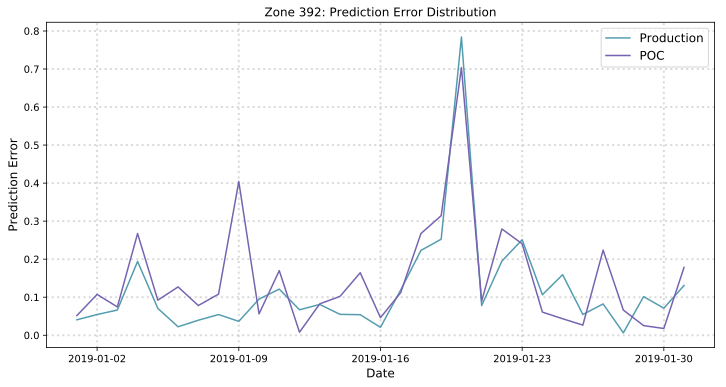

In [27]:
zone_id = 392

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.plot(df_pred[df_pred['zone_id'] == zone_id]['date'], 
         df_pred[df_pred['zone_id'] == zone_id]['ape'], 
         color='#539caf', label='Production')
ax1.plot(df_pred[df_pred['zone_id'] == zone_id]['date'], 
         df_pred[df_pred['zone_id'] == zone_id]['pred_ape'], 
         color='#7663b0', label='POC')
ax1.set_xlabel('Date',fontsize=12)
ax1.set_ylabel('Prediction Error',fontsize=12)
ax1.set_title('Zone ' + str(zone_id) + ': ' + 'Prediction Error Distribution')
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
plt.show()

In [28]:
# Get feature scores.

# importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
fscore = grid.best_estimator_.get_booster().get_score(importance_type='gain')

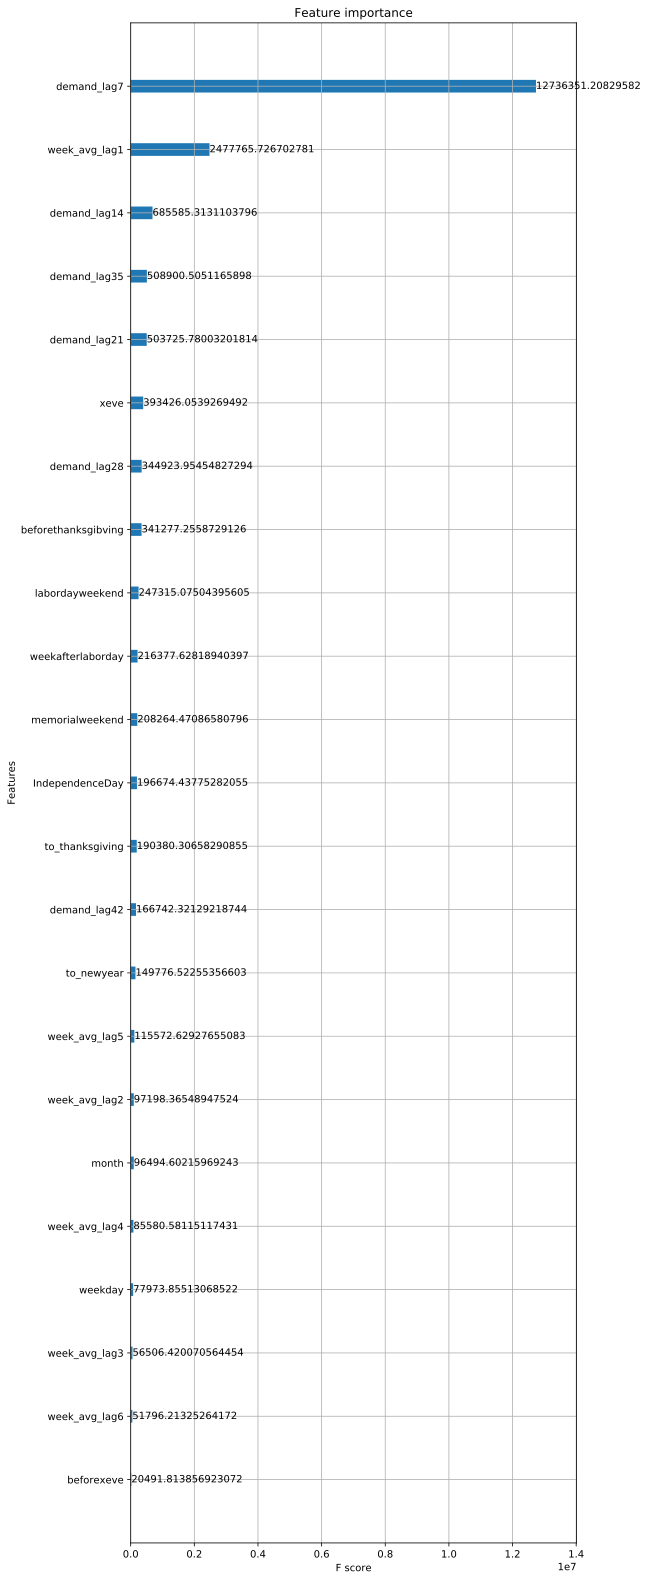

In [29]:
fig = plt.figure(figsize=(8,28))
ax = fig.add_subplot(111)
plot_importance(grid.best_estimator_, ax=ax, importance_type='gain')
plt.show()

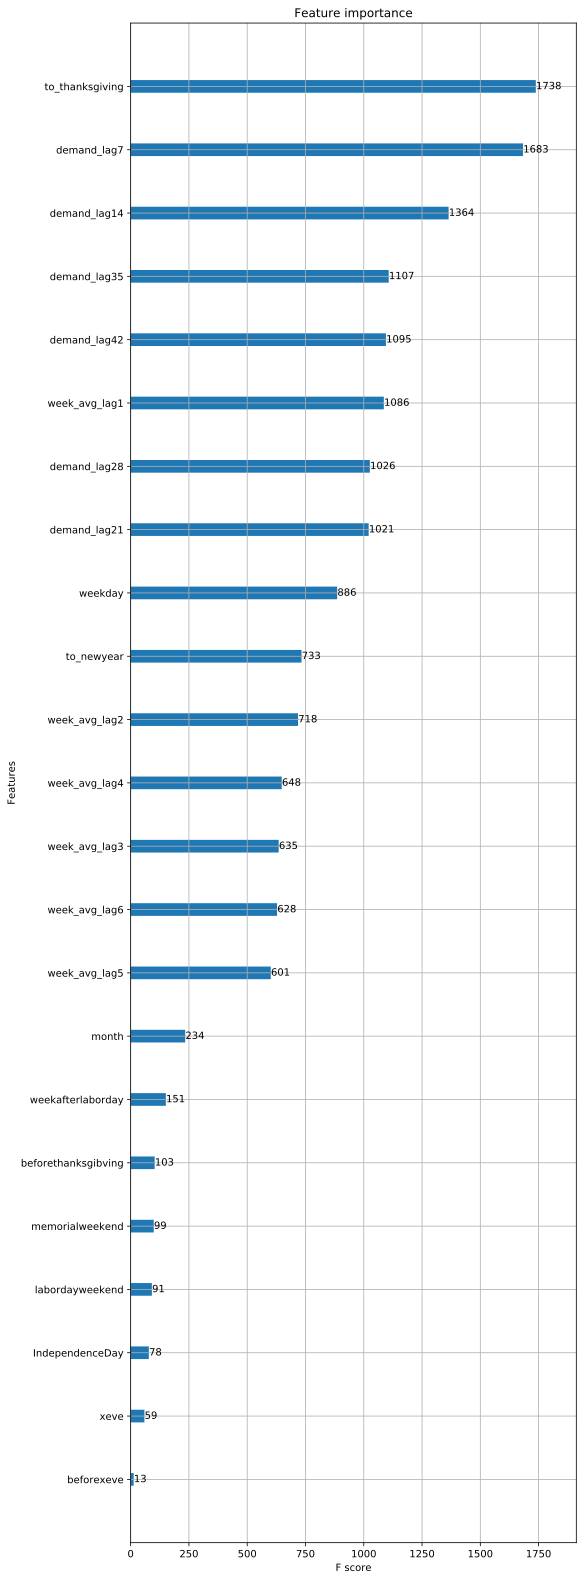

In [30]:
fig = plt.figure(figsize=(8,28))
ax = fig.add_subplot(111)
plot_importance(grid.best_estimator_, ax=ax)
plt.show()

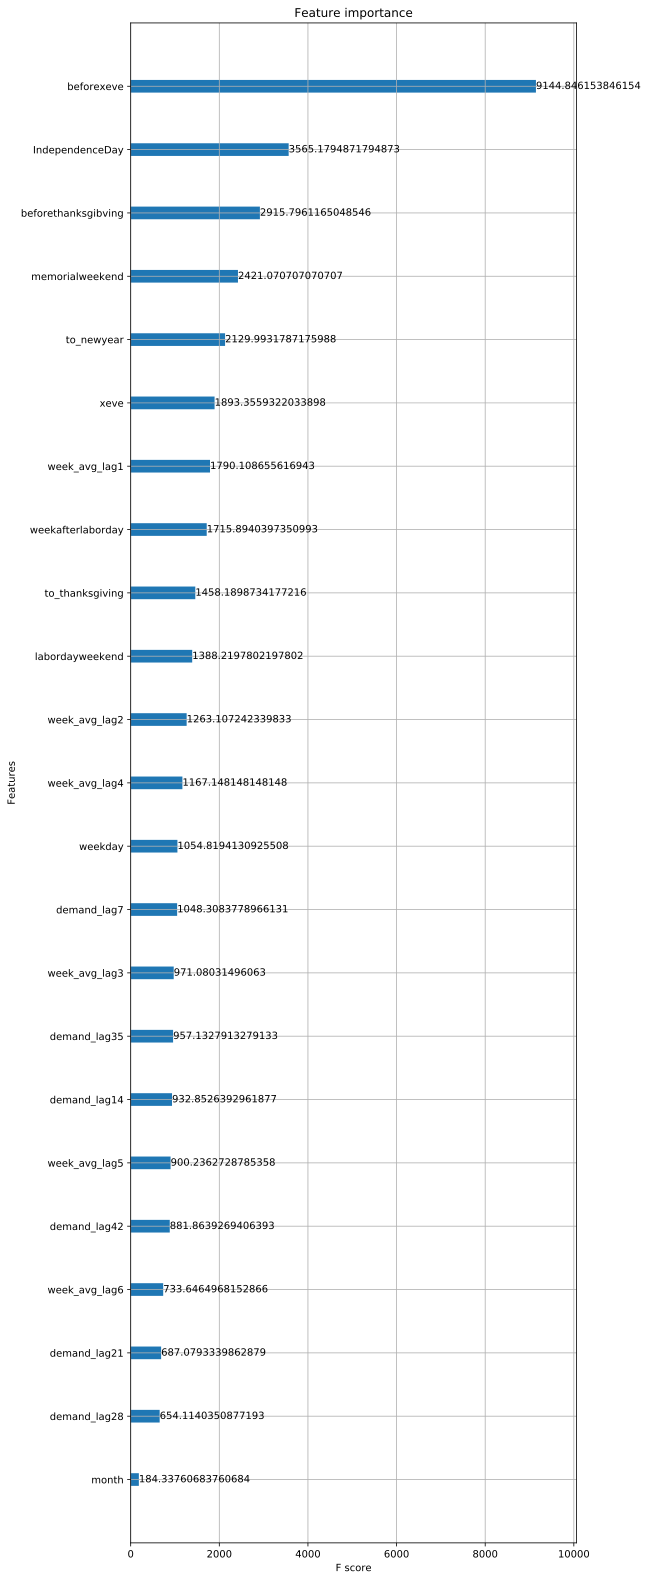

In [31]:
fig = plt.figure(figsize=(8,28))
ax = fig.add_subplot(111)
plot_importance(grid.best_estimator_, ax=ax, importance_type='cover')
plt.show()

In [32]:
fscore

{'demand_lag7': 12736351.20829582,
 'week_avg_lag1': 2477765.726702781,
 'week_avg_lag5': 115572.62927655083,
 'week_avg_lag3': 56506.420070564454,
 'demand_lag21': 503725.78003201814,
 'demand_lag14': 685585.3131103796,
 'week_avg_lag6': 51796.21325264172,
 'to_thanksgiving': 190380.30658290855,
 'demand_lag28': 344923.95454827294,
 'demand_lag42': 166742.32129218744,
 'demand_lag35': 508900.5051165898,
 'week_avg_lag4': 85580.58115117431,
 'weekday': 77973.85513068522,
 'to_newyear': 149776.52255356603,
 'IndependenceDay': 196674.43775282055,
 'xeve': 393426.0539269492,
 'week_avg_lag2': 97198.36548947524,
 'memorialweekend': 208264.47086580796,
 'month': 96494.60215969243,
 'weekafterlaborday': 216377.62818940397,
 'labordayweekend': 247315.07504395605,
 'beforethanksgibving': 341277.2558729126,
 'beforexeve': 20491.813856923072}